In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
pip install --upgrade segmentation-models-pytorch torch

In [ ]:
!pip install torchmetrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
"""
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,  RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
"""
from scipy.stats import randint
import matplotlib.pyplot as plt
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
from sklearn.model_selection import train_test_split

from skimage import transform
#import tensorflow as tf
#import segmentation_models as sm
#from tf.keras import layers, models

from PIL import Image

import seaborn as sns

torch.multiprocessing.set_start_method('spawn', force=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PYDEVD_DISABLE_FILE_VALIDATION=1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir model

In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/images'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/masks'
models_dir ='/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/models'
metrics_dir = '/content/drive/MyDrive/Colab Notebooks/AI MLCourse/Capstone/MultiSourceSatelliteImagerySegmentation/metrics'

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [ ]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

Image shape: (1479, 2149, 3)
Mask shape: (1479, 2149, 3)


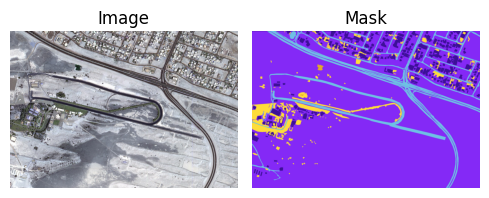

Image shape: (644, 797, 3)
Mask shape: (644, 797, 3)


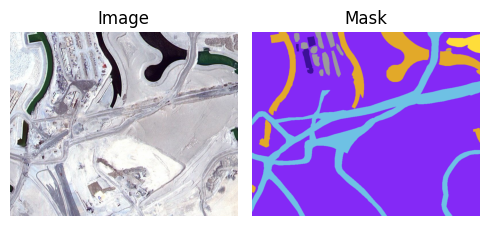

Image shape: (2557, 1887, 3)
Mask shape: (2557, 1887, 3)


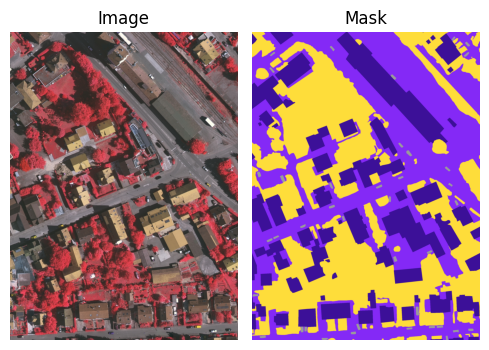

Image shape: (2557, 1887, 3)
Mask shape: (2557, 1887, 3)


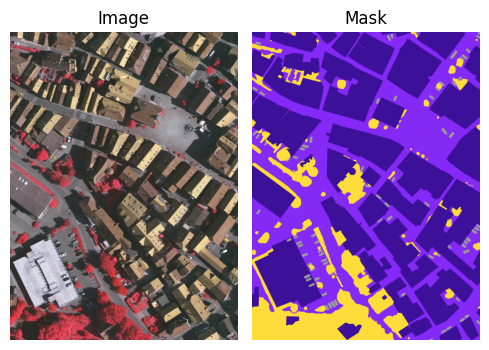

Image shape: (2565, 1919, 3)
Mask shape: (2565, 1919, 3)


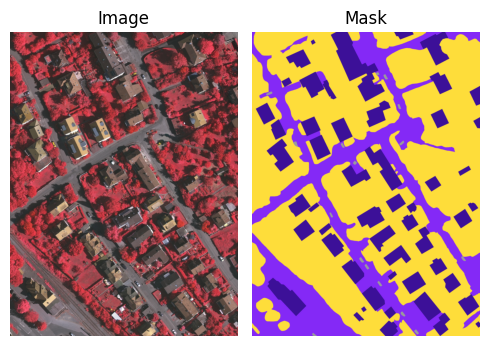

In [ ]:
#fig, axes=plt.subplots(2,5,figsize=(10,10))
#axes=axes.ravel()

def plot_image_mask_pair(image, mask, title_img="Image", title_mask="Mask"):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5)) # Create 1 row, 2 columns
    axes=axes.ravel()
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title(title_img)
    axes[0].axis('off') # Hide axes ticks

    # Plot the mask (often single channel, use a colormap)
    # Use cmap='gray' or 'viridis', 'jet' for different looks
    axes[1].imshow(mask) # For binary/single-class masks
    # axes[1].imshow(mask, cmap='viridis', vmin=0, vmax=2) # For multi-class (e.g., 3 classes)
    axes[1].set_title(title_mask)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

for i in np.arange(0, 5):
    idx=np.random.randint(0, len(train_images))
    image_data=plt.imread(os.path.join(images_dir, train_images[idx]))
    masks_data=plt.imread(os.path.join(masks_dir, train_masks[idx]))
    plot_image_mask_pair(image_data, masks_data)



In [ ]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}



In [ ]:
import torch
import segmentation_models_pytorch as smp


ENCODER='resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = len(color_map)
DEVICE='cuda:0' if torch.cuda.is_available() else 'cpu'
ACTIVATION='softmax'

def get_custom_unet(num_classes):
  model = smp.Unet(
      encoder_name=ENCODER,
      encoder_weights=ENCODER_WEIGHTS,
      #encoder_weights=None,
      #in_channels=3, # Input channels (3 for RGB images)
      classes=num_classes,
      #activation=ACTIVATION,
      activation=None
  ).to(DEVICE)
  return model

model=get_custom_unet(CLASSES)
model = model.to(torch.float64) # Changed to float32
print(model)
preprocess_input = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np


# Define the augmentation probabilities/parameters
flip_prob = 0.5
rot_degrees = 10
color_jitter_params = (0.2, 0.2, 0.2, 0.1)

# Target sizes for different models
UNET_TARGET_SIZE = (512, 512) # Original target size for UNet
DEEPLABV3_TARGET_SIZE = (520, 520) # Standard target size for torchvision DeepLabV3 models

# Transformations for images including data augmentation (for UNet)
transform_unet = transforms.Compose([
      transforms.RandomHorizontalFlip(p=flip_prob),
      transforms.RandomRotation(rot_degrees),
      transforms.Resize(UNET_TARGET_SIZE),
      transforms.ColorJitter(*color_jitter_params),
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Transformations for labels (masks) for UNet
label_transform_unet = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(UNET_TARGET_SIZE, interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# New: Explicit transformations for DeepLabV3 images
transform_deeplabv3_image = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(DEEPLABV3_TARGET_SIZE), # Ensure exact size for DeepLabV3 input LAST
    transforms.ColorJitter(*color_jitter_params),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Transformations for labels (masks) for DeepLabV3
label_transform_deeplabv3 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=flip_prob),
    transforms.RandomRotation(rot_degrees),
    transforms.Resize(DEEPLABV3_TARGET_SIZE, interpolation=Image.NEAREST), # Ensure exact size for DeepLabV3 input LAST
    transforms.ToTensor(),
])

In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [ ]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    # Removed: print(f"DEBUG: Inside rgb_to_2D_label. Input label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Ensure label is a numpy array and has 3 channels (HxWx3)
    if not isinstance(label, np.ndarray) or label.ndim != 3 or label.shape[2] != 3:
        # Removed: print(f"WARNING: Input label to rgb_to_2D_label does not have expected HxWx3 shape. Got {label.shape}")
        raise ValueError(f"Input to rgb_to_2D_label must be an HxWx3 numpy array, but got shape {label.shape}")

    height, width, _ = label.shape
    label_seg = np.zeros((height, width), dtype=np.uint8) # Initialize as a 2D array (HxW)

    # Removed: print(f"DEBUG: Type of Building: {type(Building)}, Land: {type(Land)}, Road: {type(Road)}, Vegetation: {type(Vegetation)}, Water: {type(Water)}, Unlabeled: {type(Unlabeled)}")
    # Removed: print(f"DEBUG: Building value: {Building}, type: {type(Building)}, dtype: {Building.dtype}")
    # Removed: print(f"DEBUG: Land value: {Land}, type: {type(Land)}, dtype: {Land.dtype}")
    # Removed: print(f"DEBUG: Road value: {Road}, type: {type(Road)}, dtype: {Road.dtype}")
    # Removed: print(f"DEBUG: Vegetation value: {Vegetation}, type: {type(Vegetation)}, dtype: {Vegetation.dtype}")
    # Removed: print(f"DEBUG: Water value: {Water}, type: {type(Water)}, dtype: {Water.dtype}")
    # Removed: print(f"DEBUG: Unlabeled value: {Unlabeled}, type: {type(Unlabeled)}, dtype: {Unlabeled.dtype}")

    try:
        label_seg[np.all(label == Building, axis=-1)] = 0
    except Exception as e:
        print(f"ERROR: Failed at Building comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Land, axis=-1)] = 1
    except Exception as e:
        print(f"ERROR: Failed at Land comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Road, axis=-1)] = 2
    except Exception as e:
        print(f"ERROR: Failed at Road comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Vegetation, axis=-1)] = 3
    except Exception as e:
        print(f"ERROR: Failed at Vegetation comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Water, axis=-1)] = 4
    except Exception as e:
        print(f"ERROR: Failed at Water comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    except Exception as e:
        print(f"ERROR: Failed at Unlabeled comparison: {e}")
        raise

    return label_seg

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F

class SegmentationData:
  def __init__(self, images_dir, images_list, masks_list):
    self.images_dir=images_dir
    self.images_list=images_list
    self.masks_list=masks_list

  def __len__(self):
      return len(self.images_list)

  def __getitem__(self, idx):
    image_path=os.path.join(self.images_dir, self.images_list[idx])
    image = Image.open(image_path).convert("RGB") # Ensure RGB conversion

    mask_path=os.path.join(masks_dir, self.masks_list[idx]) # Correctly use self.masks_list
    mask = Image.open(mask_path).convert("RGB") # Ensure RGB conversion

    # Apply transformations based on which model is currently being trained
    if deeplabv3_model: # Prioritize DeepLabV3 transformations
      image = transform_deeplabv3_image(image) # Use explicit DeepLabV3 image transform
      mask = label_transform_deeplabv3(mask) # Custom mask transform for DeepLabV3
      image = image.to(torch.float32)
      mask = mask.to(torch.float32)

    elif resnet_model: # Use UNet transformations if DeepLabV3 is not active
      image = transform_unet(image) # Custom image transform for UNet
      mask = label_transform_unet(mask) # Custom mask transform for UNet
      image = image.to(torch.float64)
      mask = mask.to(torch.float64)

    else: # Fallback if neither flag is set (should ideally not happen if flags are correctly managed)
      image = transform_unet(image) # Assume default to UNet's transform
      mask = label_transform_unet(mask) # Assume default to UNet's transform
      image = image.to(torch.float32)
      mask = mask.to(torch.float32)


    return image, mask

segmentation_data_train=SegmentationData(images_dir, train_images, train_masks)
segmentation_data_val=SegmentationData(images_dir, val_images, val_masks)

train_data_loader=DataLoader(segmentation_data_train, shuffle=True, pin_memory=False, num_workers=0, drop_last=True)
val_data_loader=DataLoader(segmentation_data_val, shuffle=False, pin_memory=False, num_workers=0, drop_last=True)

Segmentation mask has negative values which needs to be clamped to zero indicating imbalanced dataset which restricts model accuracy.

In [ ]:
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F
import numpy as np # Ensure numpy is imported for operations

# Assuming rgb_to_2D_label is defined globally (from cell AL_6wCXt0FJG)

def process_targets_to_2d_labels(targets_rgb, predicted_labels_device):
    """Converts a batch of RGB target masks (C, H, W) to 2D class labels (H, W)."""
    batch_size = targets_rgb.shape[0]
    processed_targets_list = []
    for i in range(batch_size):
        # targets_rgb[i] is (C, H, W). Convert to (H, W, C) numpy array for rgb_to_2D_label
        # Scale from 0-1 float to 0-255 uint8 before conversion
        target_img_chw_np = targets_rgb[i].detach().cpu().numpy()
        target_img_hwc = np.transpose((target_img_chw_np * 255).astype(np.uint8), (1, 2, 0))
        processed_targets_list.append(rgb_to_2D_label(target_img_hwc))
    # Stack them back into a batch tensor (N, H, W) and move to the device of predicted_labels
    return torch.tensor(np.stack(processed_targets_list), dtype=torch.long, device=predicted_labels_device)


class AccuracyMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Accuracy' # Name for logging in smp_utils
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        # Extract 'out' tensor if outputs is an OrderedDict (from DeepLabV3)
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.accuracy(predicted_labels, true_labels)

class PrecisionMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Precision'
        self.precision = Precision(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.precision(predicted_labels, true_labels)

class RecallMetric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'Recall'
        self.recall = Recall(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.recall(predicted_labels, true_labels)

class F1Metric(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__name__ = 'F1' # Using 'F1' as in train_logs_dict
        self.f1 = F1Score(task='multiclass', num_classes=num_classes)

    def forward(self, outputs, targets_rgb):
        if isinstance(outputs, dict):
            outputs = outputs['out']

        probabilities = F.softmax(outputs, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)[1].detach()
        true_labels = process_targets_to_2d_labels(targets_rgb, predicted_labels.device)
        return self.f1(predicted_labels, true_labels)

CLASSES = 6
# Instantiate individual metrics for use in the training loop
accuracy_metric = AccuracyMetric(CLASSES)
precision_metric = PrecisionMetric(CLASSES)
recall_metric = RecallMetric(CLASSES)
f1_metric = F1Metric(CLASSES)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-7, from_logits=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.from_logits = from_logits
        self.num_classes = num_classes

    def forward(self, inputs, targets_rgb):
        #print(f"DEBUG (DiceLoss): inputs shape: {inputs.shape}, dtype: {inputs.dtype}")
        #print(f"DEBUG (DiceLoss): targets_rgb shape: {targets_rgb.shape}, dtype: {targets_rgb.dtype}")

        # inputs: (N, CLASSES, H, W) - raw model logits
        # targets_rgb: (N, C_rgb, H, W) - RGB image tensors from DataLoader

        # Extract 'out' tensor if outputs is an OrderedDict
        if isinstance(inputs, dict):
            inputs = inputs['out']

        # 1. Convert RGB targets to 2D class labels (N, H, W)
        batch_size = targets_rgb.shape[0]
        processed_targets_list = []
        for i in range(batch_size):
            target_img_chw_np = targets_rgb[i].detach().cpu().numpy()
            target_img_hwc_np = np.transpose((target_img_chw_np * 255).astype(np.uint8), (1, 2, 0))
            processed_targets_list.append(rgb_to_2D_label(target_img_hwc_np))

        targets_2d_labels = torch.tensor(np.stack(processed_targets_list), dtype=torch.long, device=inputs.device)

        # 2. Convert 2D class labels to one-hot encoded targets (N, CLASSES, H, W)
        targets_one_hot = F.one_hot(targets_2d_labels, self.num_classes).permute(0, 3, 1, 2).to(torch.float32)

        # Make sure targets_one_hot has same dtype as inputs for element-wise ops
        targets_one_hot = targets_one_hot.to(inputs.dtype)

        # 3. Apply activation to inputs if from_logits is True
        if self.from_logits:
            probabilities = F.softmax(inputs, dim=1)
        else:
            probabilities = inputs

        # Calculate Dice Loss for each class and average them
        dice_losses = []
        for class_idx in range(self.num_classes):
            p = probabilities[:, class_idx, :, :].contiguous().view(-1) # Predicted probabilities for class_idx
            t = targets_one_hot[:, class_idx, :, :].contiguous().view(-1) # Ground truth for class_idx

            intersection = (2. * (p * t).sum() + self.smooth) / (p.sum() + t.sum() + self.smooth)
            dice_losses.append(1. - intersection)

        # Average the Dice loss across all classes
        loss = torch.stack(dice_losses).mean()

        return loss

loss=DiceLoss(CLASSES)

In [ ]:
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torch.utils.data import DataLoader
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 8


# --- Set model flags correctly for UNet training ---
deeplabv3_model = False
resnet_model = True

# Initialize dictionaries to store lists of metrics for each epoch
# The keys here must match the __name__ attribute of the metric objects
train_logs_dict = {'dice_loss': [], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}
valid_logs_dict = {'dice_loss': [], 'Accuracy': [], 'Precision':[], 'Recall':[], 'F1':[]}

# --- Re-initialize DataLoaders with updated model flags ---
segmentation_data_train=SegmentationData(images_dir, train_images, train_masks)
segmentation_data_val=SegmentationData(images_dir, val_images, val_masks)

train_data_loader=DataLoader(segmentation_data_train, shuffle=True, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)
val_data_loader=DataLoader(segmentation_data_val, shuffle=False, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)

# Ensure model is on the correct device and data type
model = model.to(device).to(torch.float64)

# Loss and Optimizer
loss = loss.to(device)
loss.__name__ = 'dice_loss' # Naming the loss for logging in smp_utils

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Move custom metrics to the device
# These individual metric instances are now defined in AZHwwXlTZZyx
accuracy_metric = accuracy_metric.to(device)
precision_metric = precision_metric.to(device)
recall_metric = recall_metric.to(device)
f1_metric = f1_metric.to(device)

# Pass all individual metric objects as a list to the runners
metrics=[accuracy_metric, precision_metric, recall_metric, f1_metric]

# Create epoch runners
train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model.eval(),
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

max_score=0
# Training Loop
for i in range(EPOCHS):
  print(f'\nEpoch: {i+1}')
  for batch in train_data_loader:
    image = batch[0].to(device)
    mask = batch[1].to(device)
    train_logs = train_epoch.run(train_data_loader)
    with torch.no_grad():
      valid_logs = valid_epoch.run(val_data_loader)

    # Append the current epoch's results to the history lists
    for key in train_logs_dict.keys():
        if key in train_logs:
            train_logs_dict[key].append(train_logs[key])
        else:
            print(f"Warning: Key '{key}' not found in train_logs for current epoch.")

    for key in valid_logs_dict.keys():
        if key in valid_logs:
            valid_logs_dict[key].append(valid_logs[key])
        else:
            print(f"Warning: Key '{key}' not found in valid_logs for current epoch.")
  # Memory clean up
  del image, mask
  gc.collect()

    # Optional: Save the best model, using F1-score as the primary metric
  if 'F1' in valid_logs and valid_logs['F1'] > max_score:
    max_score = valid_logs['F1']
    #torch.save(model.state_dict(), './model/unet_best_model.pth')
    torch.save(model.state_dict(), os.path.join(model_dir, 'unet_best_model.pth'))
    print('Model saved!')

  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 5/5 [01:25<00:00, 17.08s/it, dice_loss - 0.751, Accuracy - 0.5279, Precision - 0.5279, Recall - 0.5279, F1 - 0.5279]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:33<00:00,  6.76s/it, dice_loss - 0.7072, Accuracy - 0.5332, Precision - 0.5332, Recall - 0.5332, F1 - 0.5332]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:33<00:00,  6.72s/it, dice_loss - 0.6946, Accuracy - 0.5378, Precision - 0.5378, Recall - 0.5378, F1 - 0.5378]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:33<00:00,  6.79s/it, dice_loss - 0.7052, Accuracy - 0.5561, Precision - 0.5561, Recall - 0.5561, F1 - 0.5561]
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:33<00:00,  6.77s/it, dice_loss - 0.6966, Accuracy - 0.5343, Precision - 0.5343, Recall - 0.5343, F1 - 0.5343]

Epoch: 6
valid: 100%|██████████| 5/5 [00:34<00:00,  6.83s/it, dice_loss - 0.6987, Accuracy - 0.5134, Precision - 0.5134, Recall - 0.5134, F1 - 0.5134]

Epoch: 7
valid: 100%|██████████| 5/5

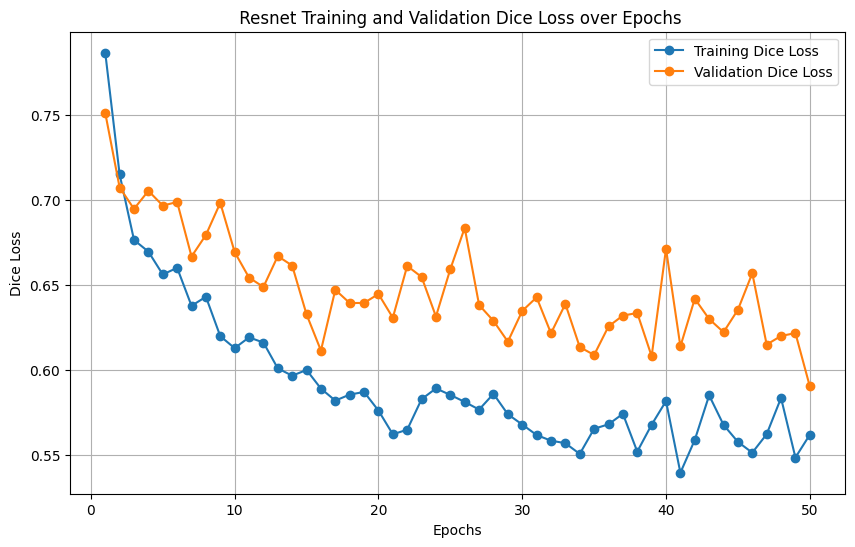

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['dice_loss'], label='Training Dice Loss', marker='o')
plt.plot(epochs_range, valid_logs_dict['dice_loss'], label='Validation Dice Loss', marker='o')
plt.title(' Resnet Training and Validation Dice Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid(True)
plt.savefig('./images/resnet_dice_loss.png')
plt.show()


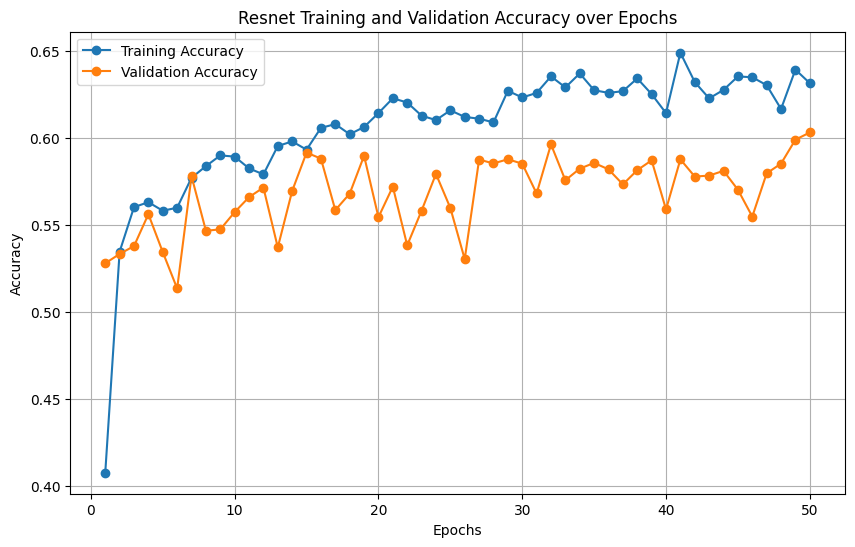

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['Accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, valid_logs_dict['Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Resnet Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(metrics_dir, 'resnet_accuracy.png'))
#plt.savefig('./images/resnet_accuracy.png')
plt.show()

In [ ]:
import numpy as np

def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask

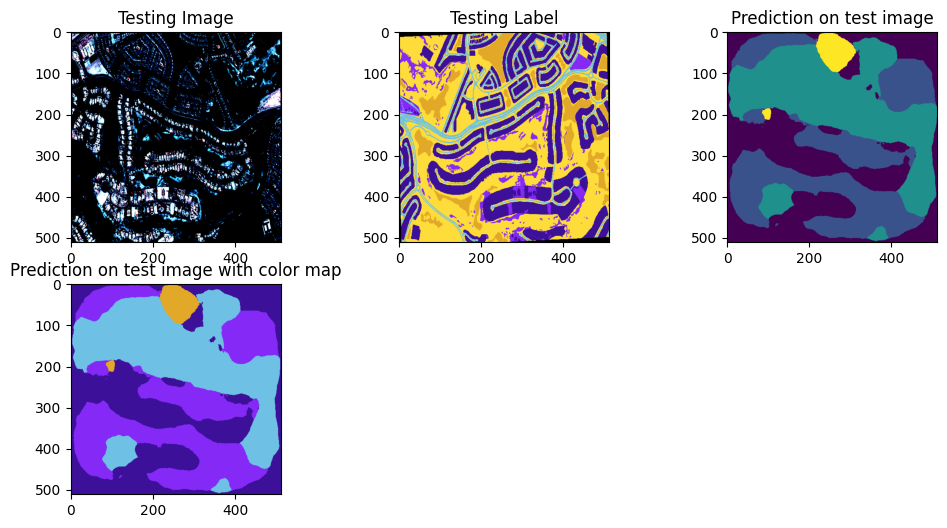

In [ ]:
import random
test_img_number = random.randint(0, len(val_data_loader)-1)
val_dataset = val_data_loader.dataset
test_img, test_mask = val_dataset[test_img_number]
test_img_batch = test_img.unsqueeze(0)


#model.load_state_dict(torch.load('./model/unet_best_model.pth'))
model.load_state_dict(torch.load(os.path.join(model_dir, 'unet_best_model.pth')))
model.to(device) # Move model to device after loading state_dict
model.eval()


prediction = model(test_img_batch.to(device))
prediction = prediction.cpu().detach().numpy()
prediction = np.argmax(prediction, axis=1).squeeze(0) # Corrected: argmax on axis=1 and squeeze batch dim

#apply color mask
colored_mask = apply_color_map(prediction, color_map)

plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img.permute(1, 2, 0))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask.permute(1, 2, 0))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.subplot(234) # Corrected subplot index
plt.title('Prediction on test image with color map')
plt.imshow(colored_mask)
plt.show()



In [ ]:
import torchvision
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
# Removed: preprocess= weights.transforms() - will use custom defined transforms instead

# 1. Instantiate model
model2 = torchvision.models.segmentation.deeplabv3_resnet101(weights=weights)

# 2. Modify the classifier for your custom number of classes (e.g., 6)
num_classes = 6
# Corrected: The input to classifier[4] is 256 channels, not 512.
model2.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# 3. Modify the auxiliary classifier (if used)
# Corrected: The input to aux_classifier[4] is 256 channels.
model2.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

model2 = model2.to(torch.float32) # Changed to float32

print(model2)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 198MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# Test __getitem__ directly
print("Testing SegmentationData.__getitem__ for a single item...")
try:
    # Try to load the first item from the training dataset
    test_image, test_mask = segmentation_data_train[0]
    print(f"Successfully loaded item 0. Image shape: {test_image.shape}, Mask shape: {test_mask.shape}")
    print(f"Image dtype: {test_image.dtype}, Mask dtype: {test_mask.dtype}")
    print("Test successful!")
except Exception as e:
    print(f"Error when testing SegmentationData.__getitem__: {e}")
    import traceback
    traceback.print_exc()

Testing SegmentationData.__getitem__ for a single item...
Successfully loaded item 0. Image shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([3, 512, 512])
Image dtype: torch.float64, Mask dtype: torch.float64
Test successful!


In [ ]:
from functools import cache
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
from torch.utils.data import DataLoader
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device ="cpu"
EPOCHS = 50
BATCH_SIZE = 4 # Reduced batch size to mitigate OutOfMemoryError


# Initialize dictionaries to store lists of metrics for each epoch
train_logs_dict = {'dice_loss': [], 'Accuracy': [], 'Precision':[], 'Recall':[], 'F1':[]}
valid_logs_dict = {'dice_loss': [], 'Accuracy': [], 'Precision':[], 'Recall':[], 'F1':[]}

# --- Memory Cleanup for previous model (UNet) ---
# Ensure model variable exists before attempting to delete it
if 'model' in locals() and model is not None:
    try:
        model.cpu() # Move to CPU first if it's on GPU
        del model   # Delete the model object
        print("UNet model ('model') deleted from memory.")
    except Exception as e:
        print(f"Error deleting UNet model: {e}")

# Clear CUDA cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

# --- Set model flags for DeepLabV3 training ---
deeplabv3_model = True
resnet_model = False # Explicitly set UNet model flag to False

# --- Re-initialize DataLoaders with the specific BATCH_SIZE for model2 training ---
segmentation_data_train=SegmentationData(images_dir, train_images, train_masks)
segmentation_data_val=SegmentationData(images_dir, val_images, val_masks)

train_data_loader=DataLoader(segmentation_data_train, shuffle=True, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)
val_data_loader=DataLoader(segmentation_data_val, shuffle=False, pin_memory=False, num_workers=0, drop_last=True, batch_size=BATCH_SIZE)

# Ensure model2 is on the correct device and data type
model2 = model2.to(device) # .to(torch.float32) is already done in C1fpkYJkwKO2

# Loss and Optimizer
loss = loss.to(device)
loss.__name__ = 'dice_loss'

optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001) # Corrected: Optimize model2.parameters()
# The optimizer steps are handled by the smp_utils.train.TrainEpoch runner.
# These calls are redundant here:
# optimizer.zero_grad(set_to_none=True)
# optimizer.step()

accuracy_metric = accuracy_metric.to(device)
precision_metric = precision_metric.to(device)
recall_metric = recall_metric.to(device)
f1_metric = f1_metric.to(device)

metrics=[accuracy_metric, precision_metric, recall_metric, f1_metric]

# Create epoch runners
train_epoch = smp_utils.train.TrainEpoch(
    model2,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model2.eval(),
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True,
)

max_score=0
# Training Loop
for i in range(EPOCHS):
  print(f'\nEpoch: {i+1}')
  for batch in train_data_loader:
    image = image.to(device)
    mask = mask.to(device)
    train_logs = train_epoch.run(train_data_loader)
    with torch.no_grad():
      valid_logs = valid_epoch.run(val_data_loader)

    # Append the current epoch's results to the history lists
    for key in train_logs_dict.keys():
        if key in train_logs:
          train_logs_dict[key].append(train_logs[key])
        else:
          print(f"Warning: Key '{key}' not found in train_logs for current epoch.")

    for key in valid_logs_dict.keys():
        if key in valid_logs:
          valid_logs_dict[key].append(valid_logs[key])
        else:
          print(f"Warning: Key '{key}' not found in valid_logs for current epoch.")
  # Memory clean up
  del image, mask
  gc.collect()

    # Optional: Save the best model
  if 'Accuracy' in valid_logs and valid_logs['Accuracy'] > max_score: # Use 'Accuracy' or other relevant metric from valid_logs
    max_score = valid_logs['Accuracy']
    #torch.save(model2.state_dict(), './model/deeplabv3_best_model.pth')
    torch.save(model2.state_dict(), os.path.join(model_dir, 'deeplabv3_best_model.pth')
    print('Model saved!')

  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

UNet model ('model') deleted from memory.
CUDA cache cleared.

Epoch: 1
valid: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it, dice_loss - 0.7363, Accuracy - 0.5741, Precision - 0.5741, Recall - 0.5741, F1 - 0.5741]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it, dice_loss - 0.7403, Accuracy - 0.5378, Precision - 0.5378, Recall - 0.5378, F1 - 0.5378]

Epoch: 3
valid: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it, dice_loss - 0.7123, Accuracy - 0.5808, Precision - 0.5808, Recall - 0.5808, F1 - 0.5808]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:24<00:00,  2.48s/it, dice_loss - 0.709, Accuracy - 0.5285, Precision - 0.5285, Recall - 0.5285, F1 - 0.5285]

Epoch: 5
valid: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it, dice_loss - 0.694, Accuracy - 0.572, Precision - 0.572, Recall - 0.572, F1 - 0.572]

Epoch: 6
valid: 100%|██████████| 10/10 [00:24<00:00,  2.40s/it, dice_loss - 0.6909, Accuracy - 0.5741, Precision - 0.5741, Recall - 0.5741, F1 - 0.

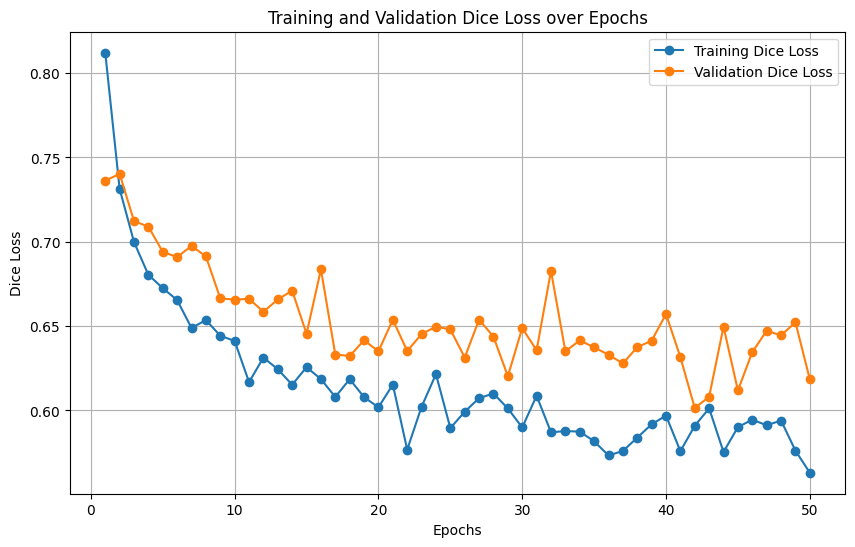

In [ ]:

import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['dice_loss'], label='Training Dice Loss', marker='o')
plt.plot(epochs_range, valid_logs_dict['dice_loss'], label='Validation Dice Loss', marker='o')
plt.title('Training and Validation Dice Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid(True)
#plt.savefig('./images/deeplabv3_dice_loss.png')
plt.savefig(os.path.join(metrics_dir, 'deeplabv3_dice_loss.png')
plt.show()


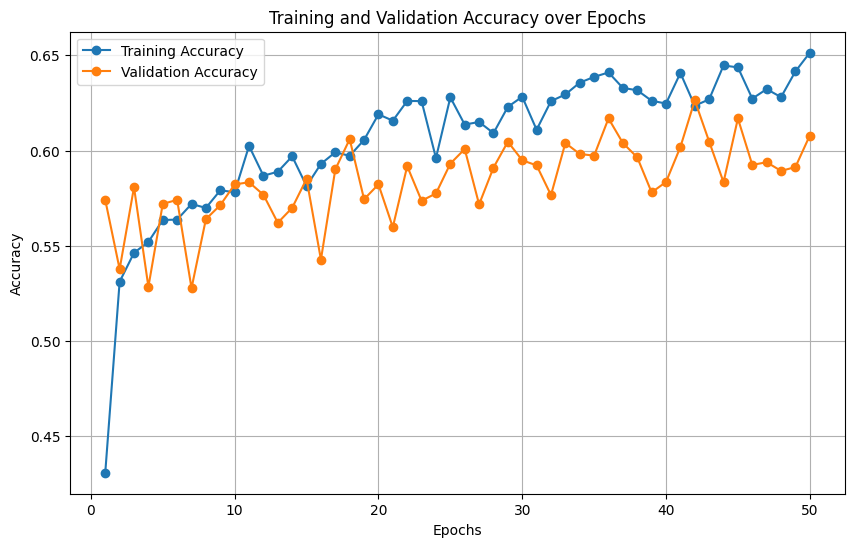

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_logs_dict['Accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, valid_logs_dict['Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
#plt.savefig('./images/deeplabv3_accuracy.png')
plt.savefig(os.path.join(metrics_dir, 'deeplabv3_accuracy.png')
plt.show()

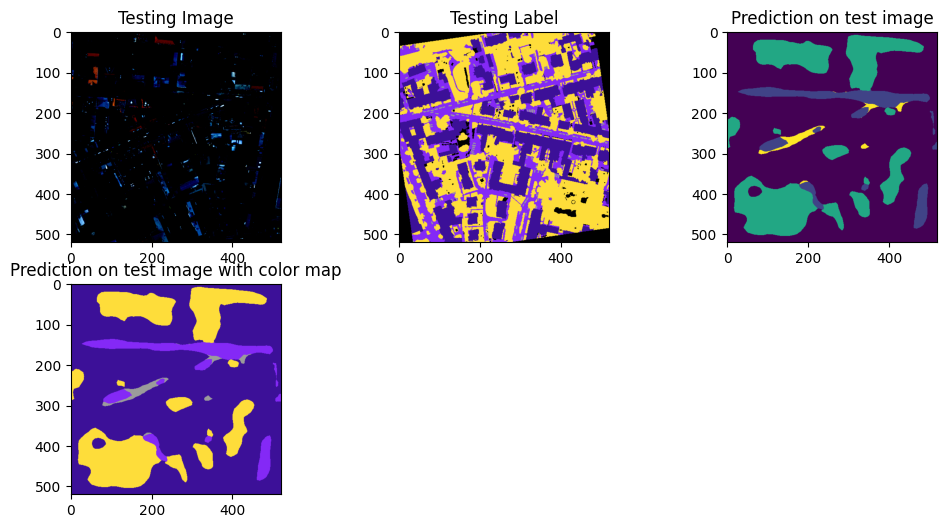

In [ ]:
import random
test_img_number = random.randint(0, len(val_data_loader)-1)
val_dataset = val_data_loader.dataset
test_img, test_mask = val_dataset[test_img_number]
test_img_batch = test_img.unsqueeze(0)


#model2.load_state_dict(torch.load('./model/deeplabv3_best_model.pth'))
model2.load_state_dict(torch.load(os.path.join(model_dir, 'deeplabv3_best_model.pth')
model2.to(device) # Move model to device after loading state_dict
model2.eval()

prediction = model2(test_img_batch.to(device))
prediction = prediction['out'].squeeze(0)
prediction = prediction.cpu().detach().numpy()
prediction = np.argmax(prediction, axis=0)

#apply color mask
colored_mask = apply_color_map(prediction, color_map)

plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img.permute(1, 2, 0))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask.permute(1, 2, 0))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.subplot(234)
plt.title('Prediction on test image with color map')
plt.imshow(colored_mask)
plt.show()